<a href="https://colab.research.google.com/github/kmin0528/Crime-Type-Classification-AI/blob/main/Dacon_Crime_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**필요 라이브러리 설치**

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tpot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1. 라이브러리 Load

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from pycaret.classification import *
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from category_encoders.cat_boost import CatBoostEncoder
from tpot import TPOTClassifier

from tensorflow.keras.utils import to_categorical

plt.rc('font', family='NanumBarunGothic') 

## 1-1. 사용자 함수 정의

In [ ]:
# 변수 중요도 plot
def plot_feature_importance(importance, names, topn = 'all'):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('importance')
    plt.ylabel('feature names')
    plt.rc('font', family='NanumBarunGothic') 
    plt.grid()

    return fi_df

In [1]:
# optuna 모듈로 정의
def objective(trial):
    model = CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth = trial.suggest_int("depth", 1, 16),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return f1_score(y_test, y_pred, average="macro")

## 1-2. Data 불러오기
- 데이터 형태
- 결측치 확인

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/open (2)/train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84406 entries, 0 to 84405
Data columns (total 20 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ID       84406 non-null  object 
 1   월        84406 non-null  int64  
 2   요일       84406 non-null  object 
 3   시간       84406 non-null  int64  
 4   소관경찰서    84406 non-null  int64  
 5   소관지역     84406 non-null  float64
 6   사건발생거리   84406 non-null  float64
 7   강수량(mm)  84406 non-null  float64
 8   강설량(mm)  84406 non-null  float64
 9   적설량(cm)  84406 non-null  float64
 10  풍향       84406 non-null  float64
 11  안개       84406 non-null  float64
 12  짙은안개     84406 non-null  float64
 13  번개       84406 non-null  float64
 14  진눈깨비     84406 non-null  float64
 15  서리       84406 non-null  float64
 16  연기/연무    84406 non-null  float64
 17  눈날림      84406 non-null  float64
 18  범죄발생지    84406 non-null  object 
 19  TARGET   84406 non-null  int64  
dtypes: float64(13), int64(4), object(3)
memory usage: 

# 2. Data 확인 

In [ ]:
df.head(5)

,ID,월,요일,시간,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),풍향,안개,짙은안개,번개,진눈깨비,서리,연기/연무,눈날림,범죄발생지,TARGET
0,TRAIN_00000,9,화요일,10,137,8.0,2.611124,0.000,0.0,0.0,245.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,2
1,TRAIN_00001,11,화요일,6,438,13.0,3.209093,0.000,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,0
2,TRAIN_00002,8,일요일,6,1729,47.0,1.619597,0.000,0.0,0.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,인도,1
3,TRAIN_00003,5,월요일,6,2337,53.0,1.921615,11.375,0.0,0.0,225.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,주거지,1
4,TRAIN_00004,9,일요일,11,1439,41.0,1.789721,0.000,0.0,0.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,주유소,2


In [ ]:
df.isnull().sum()

ID         0
월          0
요일         0
시간         0
소관경찰서      0
소관지역       0
사건발생거리     0
강수량(mm)    0
강설량(mm)    0
적설량(cm)    0
풍향         0
안개         0
짙은안개       0
번개         0
진눈깨비       0
서리         0
연기/연무      0
눈날림        0
범죄발생지      0
TARGET     0
dtype: int64

In [ ]:
df["ID"].unique()

array(['TRAIN_00000', 'TRAIN_00001', 'TRAIN_00002', ..., 'TRAIN_84403',
       'TRAIN_84404', 'TRAIN_84405'], dtype=object)

In [ ]:
df["범죄발생지"].unique()

array(['차도', '인도', '주거지', '주유소', '주차장', '편의점', '학교', '식당', '백화점', '약국',
       '호텔/모텔', '은행', '병원', '공원'], dtype=object)

## 2-1. 범주형 변수 처리
- pd.get_dummies 활용
- 예측에 사용하지 않을 컬럼 제거 

In [ ]:
df.drop(columns = ["ID"],inplace=True)

In [ ]:
df.head(3)

,월,요일,시간,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),풍향,안개,짙은안개,번개,진눈깨비,서리,연기/연무,눈날림,범죄발생지,TARGET
0,9,화요일,10,137,8.0,2.611124,0.0,0.0,0.0,245.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,2
1,11,화요일,6,438,13.0,3.209093,0.0,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,0
2,8,일요일,6,1729,47.0,1.619597,0.0,0.0,0.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,인도,1


In [ ]:
df = pd.get_dummies(df, columns=["요일","범죄발생지"])
df.head(5)

,월,시간,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),풍향,안개,...,범죄발생지_약국,범죄발생지_은행,범죄발생지_인도,범죄발생지_주거지,범죄발생지_주유소,범죄발생지_주차장,범죄발생지_차도,범죄발생지_편의점,범죄발생지_학교,범죄발생지_호텔/모텔
0,9,10,137,8.0,2.611124,0.000,0.0,0.0,245.0,0.0,...,0,0,0,0,0,0,1,0,0,0
1,11,6,438,13.0,3.209093,0.000,0.0,0.0,200.0,0.0,...,0,0,0,0,0,0,1,0,0,0
2,8,6,1729,47.0,1.619597,0.000,0.0,0.0,40.0,1.0,...,0,0,1,0,0,0,0,0,0,0
3,5,6,2337,53.0,1.921615,11.375,0.0,0.0,225.0,1.0,...,0,0,0,1,0,0,0,0,0,0
4,9,11,1439,41.0,1.789721,0.000,0.0,0.0,255.0,0.0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
df.head(3)

,월,시간,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),풍향,안개,...,범죄발생지_약국,범죄발생지_은행,범죄발생지_인도,범죄발생지_주거지,범죄발생지_주유소,범죄발생지_주차장,범죄발생지_차도,범죄발생지_편의점,범죄발생지_학교,범죄발생지_호텔/모텔
0,9,10,137,8.0,2.611124,0.0,0.0,0.0,245.0,0.0,...,0,0,0,0,0,0,1,0,0,0
1,11,6,438,13.0,3.209093,0.0,0.0,0.0,200.0,0.0,...,0,0,0,0,0,0,1,0,0,0
2,8,6,1729,47.0,1.619597,0.0,0.0,0.0,40.0,1.0,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84406 entries, 0 to 84405
Data columns (total 38 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   월            84406 non-null  int64  
 1   시간           84406 non-null  int64  
 2   소관경찰서        84406 non-null  int64  
 3   소관지역         84406 non-null  float64
 4   사건발생거리       84406 non-null  float64
 5   강수량(mm)      84406 non-null  float64
 6   강설량(mm)      84406 non-null  float64
 7   적설량(cm)      84406 non-null  float64
 8   풍향           84406 non-null  float64
 9   안개           84406 non-null  float64
 10  짙은안개         84406 non-null  float64
 11  번개           84406 non-null  float64
 12  진눈깨비         84406 non-null  float64
 13  서리           84406 non-null  float64
 14  연기/연무        84406 non-null  float64
 15  눈날림          84406 non-null  float64
 16  TARGET       84406 non-null  int64  
 17  요일_금요일       84406 non-null  uint8  
 18  요일_목요일       84406 non-null  uint8  
 19  요일_수

In [ ]:
df.columns

Index(['ID', '월', '시간', '소관경찰서', '소관지역', '사건발생거리', '강수량(mm)', '강설량(mm)',
       '적설량(cm)', '풍향', '안개', '짙은안개', '번개', '진눈깨비', '서리', '연기/연무', '눈날림',
       'TARGET', '요일_금요일', '요일_목요일', '요일_수요일', '요일_월요일', '요일_일요일', '요일_토요일',
       '요일_화요일', '범죄발생지_공원', '범죄발생지_백화점', '범죄발생지_병원', '범죄발생지_식당', '범죄발생지_약국',
       '범죄발생지_은행', '범죄발생지_인도', '범죄발생지_주거지', '범죄발생지_주유소', '범죄발생지_주차장',
       '범죄발생지_차도', '범죄발생지_편의점', '범죄발생지_학교', '범죄발생지_호텔/모텔'],
      dtype='object')

## 2-2. Target 변수 정의
- x, y값
- train_test_split을 사용하여 분리

In [ ]:
target = df["TARGET"]
y = target
x = df.drop(columns = ["TARGET"])


x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Classifier 모델링

## 3-1. StackingClassifier 사용
- RandomForest
- XGBoost
- AdaBoost
- GradientBoost

In [ ]:

from sklearn.pipeline import make_union
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from catboost import CatBoostClassifier
from imblearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier, AdaBoostClassifier, RandomForestClassifier


tree_model = DecisionTreeClassifier(max_depth=14,
                                    random_state =42)

cb_model = CatBoostClassifier(iterations=500,
                           depth= 3,
                           learning_rate=0.1,
                           random_state = 42,
                           verbose=True,
                           )

models = [('rf_model',RandomForestClassifier(n_estimators=170, 
                                  max_depth=27,
                                  max_features=5,
                                  min_samples_split =2,
                                  random_state=42, 
                                  n_jobs=-1)),

        ('xgb_model',XGBClassifier(n_estimator=170, 
                          learning_rate=0.08, 
                          max_depth=13,
                          subsample = 0.9,
                          colsample_bytree = 0.5,
                          reg_lambda = 0.5,
                          reg_alpha = 0.1,                 
                          )),
          
         ('ab_model',AdaBoostClassifier(base_estimator = tree_model, 
                             n_estimators=170,
                             random_state =42,
                             learning_rate = 0.01)),
          
         ("gb_model", GradientBoostClassifier(n_estimators=170,
                                              learning_rate = 0.02,
                                              max_depth = 10))
         ]

clf = StackingClassifier(estimators=models)


In [ ]:
lgbm_model = LGBMClassifier(
            n_estimators=2500,
            learning_rate=0.01,
            random_state=42,
            max_depth=25,
            num_leaves=700,
            min_child_samples=3,
            subsample = 0.1,
            colsample_bytree=0.2,
            max_bin=500, 
            reg_lambda=0.1,
            reg_alpha=0.06  
        )

In [ ]:
lgbm_model.fit(x_train, y_train)
cb_model.fit(x_train, y_train)
clf.fit(x_train,y_train)

0:	learn: 1.0815838	total: 68ms	remaining: 33.9s
1:	learn: 1.0682505	total: 85.2ms	remaining: 21.2s
2:	learn: 1.0571814	total: 103ms	remaining: 17.1s
3:	learn: 1.0486711	total: 121ms	remaining: 14.9s
4:	learn: 1.0411093	total: 138ms	remaining: 13.7s
5:	learn: 1.0345577	total: 157ms	remaining: 12.9s
6:	learn: 1.0290600	total: 174ms	remaining: 12.2s
7:	learn: 1.0236215	total: 191ms	remaining: 11.7s
8:	learn: 1.0187071	total: 209ms	remaining: 11.4s
9:	learn: 1.0151966	total: 225ms	remaining: 11s
10:	learn: 1.0119985	total: 242ms	remaining: 10.8s
11:	learn: 1.0094355	total: 258ms	remaining: 10.5s
12:	learn: 1.0067146	total: 279ms	remaining: 10.4s
13:	learn: 1.0044456	total: 295ms	remaining: 10.2s
14:	learn: 1.0023442	total: 311ms	remaining: 10.1s
15:	learn: 1.0002357	total: 328ms	remaining: 9.92s
16:	learn: 0.9986293	total: 344ms	remaining: 9.77s
17:	learn: 0.9969398	total: 360ms	remaining: 9.65s
18:	learn: 0.9957600	total: 377ms	remaining: 9.55s
19:	learn: 0.9943312	total: 393ms	remaining

StackingClassifier(estimators=[('rf_model',
                                RandomForestClassifier(max_depth=27,
                                                       max_features=5,
                                                       n_estimators=170,
                                                       n_jobs=-1,
                                                       random_state=42)),
                               ('xgb_model',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.5,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              featu...
                                              max_delta_step=None, max_depth=13,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimator=170, n_estimators=100,
                                              n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, ...)),
                               ('ab_model',
                                AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=14,
                                                                                         random_state=42),
                                                   learning_rate=0.01,
                                                   n_estimators=170,
                                                   random_state=42))])

In [ ]:
lgbm_pred = lgbm_model.predict(test_df)
clf_pred = clf.predict(test_df)
cb_pred = cb_model.predict(test_df)

final_outputs = {
    'lgbm' : lgbm_pred,
    'clf' : clf_pred,
    'catboost' : cb_pred,
}

In [ ]:
result['TARGET'] = cb_pred
result.to_csv('20230527_3.csv', index=False)

In [ ]:
result

,ID,TARGET
0,TEST_00000,2
1,TEST_00001,0
2,TEST_00002,0
3,TEST_00003,0
4,TEST_00004,0
...,...,...
17284,TEST_17284,1
17285,TEST_17285,0
17286,TEST_17286,0
17287,TEST_17287,0


In [ ]:
print(classification_report(y_test,results))

              precision    recall  f1-score   support

           0       0.56      0.74      0.64     10919
           1       0.59      0.43      0.50      7642
           2       0.48      0.38      0.42      6761

    accuracy                           0.55     25322
   macro avg       0.54      0.52      0.52     25322
weighted avg       0.55      0.55      0.54     25322



In [ ]:
final = exported_pipeline.predict(test_df)

final

array([2, 0, 0, ..., 0, 0, 1])

In [ ]:
result["TARGET"] = final
result

,ID,TARGET
0,TEST_00000,2
1,TEST_00001,0
2,TEST_00002,0
3,TEST_00003,0
4,TEST_00004,0
...,...,...
17284,TEST_17284,1
17285,TEST_17285,0
17286,TEST_17286,0
17287,TEST_17287,0


In [ ]:
result.to_csv("stacking.csv",index = False )

## 3-2. 모델 변수 중요도 확인 

In [ ]:
from lightgbm import LGBMClassifier

model_lgb = LGBMClassifier()
model_lgb.fit(x_train,y_train)

LGBMClassifier()

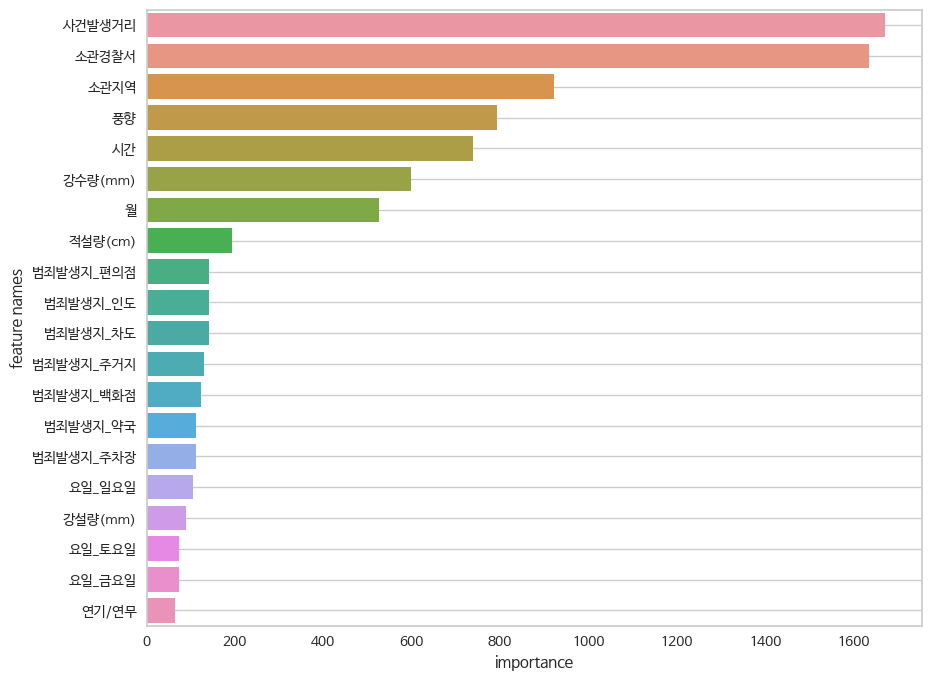

In [ ]:
plot_feature_importance(model_lgb.feature_importances_, list(x),20)
plt.rc('font', family='NanumBarunGothic') 

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

model_gbc = GradientBoostingClassifier()

model_gbc.fit(x_train,y_train)

GradientBoostingClassifier()

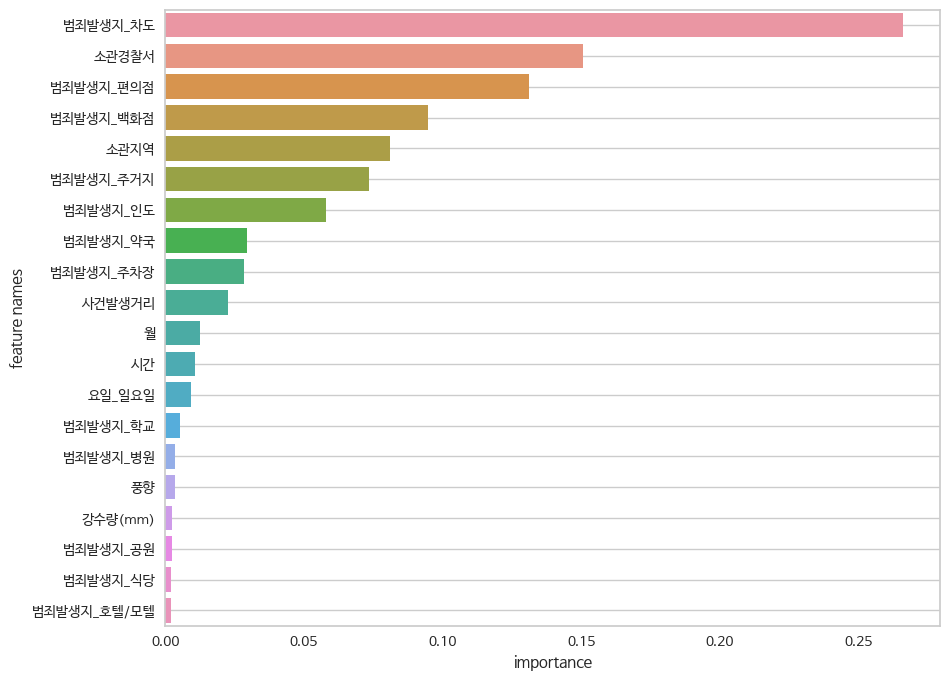

In [ ]:
plot_feature_importance(model_gbc.feature_importances_, list(x),20)
plt.rc('font', family='NanumBarunGothic') 

In [ ]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier()
model_xgb.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

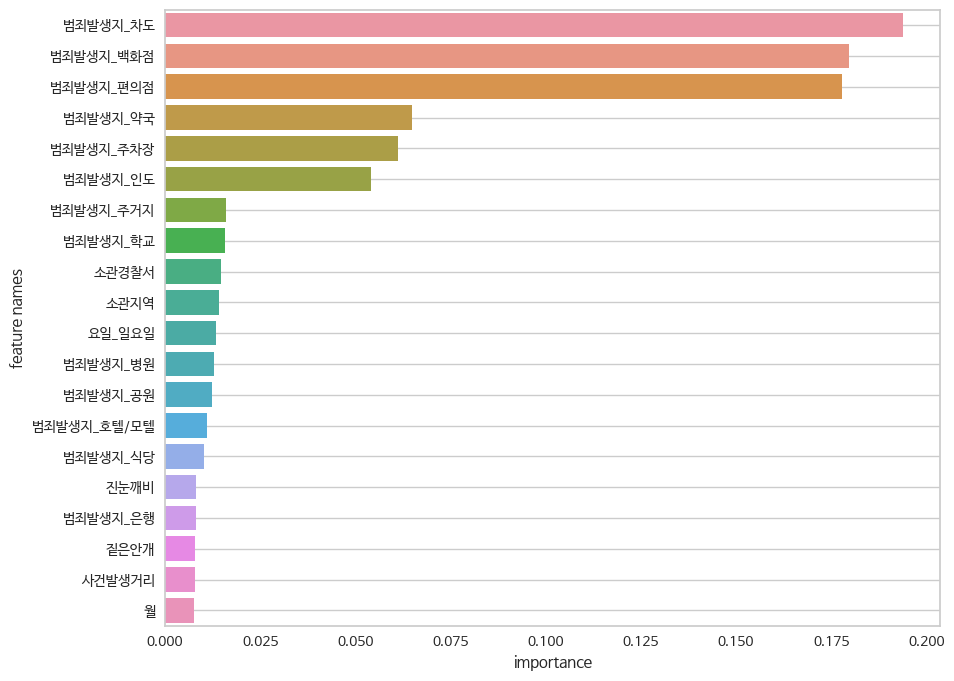

In [ ]:
plot_feature_importance(model_xgb.feature_importances_, list(x),20)
plt.rc('font', family='NanumBarunGothic') 

In [ ]:
from catboost import CatBoostClassifier

model_cb = CatBoostClassifier(learning_rate = 0.2304081632653061, max_depth = 3, n_estimators = 170)
model_cb.fit(x_train,y_train)

0:	learn: 1.0622713	total: 67.8ms	remaining: 11.5s
1:	learn: 1.0413718	total: 88.3ms	remaining: 7.42s
2:	learn: 1.0247311	total: 108ms	remaining: 6.01s
3:	learn: 1.0151871	total: 127ms	remaining: 5.28s
4:	learn: 1.0073469	total: 147ms	remaining: 4.85s
5:	learn: 1.0025123	total: 166ms	remaining: 4.53s
6:	learn: 0.9980920	total: 185ms	remaining: 4.3s
7:	learn: 0.9946296	total: 205ms	remaining: 4.14s
8:	learn: 0.9917472	total: 229ms	remaining: 4.09s
9:	learn: 0.9897556	total: 247ms	remaining: 3.96s
10:	learn: 0.9877081	total: 265ms	remaining: 3.83s
11:	learn: 0.9859304	total: 287ms	remaining: 3.78s
12:	learn: 0.9845734	total: 308ms	remaining: 3.72s
13:	learn: 0.9833323	total: 338ms	remaining: 3.77s
14:	learn: 0.9825128	total: 358ms	remaining: 3.69s
15:	learn: 0.9817886	total: 375ms	remaining: 3.61s
16:	learn: 0.9807280	total: 395ms	remaining: 3.56s
17:	learn: 0.9800952	total: 413ms	remaining: 3.49s
18:	learn: 0.9791485	total: 434ms	remaining: 3.45s
19:	learn: 0.9786945	total: 453ms	remain

## 3-3. CatBoostClassifier Params 튜닝
- optuna를 활용한 튜닝
- 튜닝과정 및 history 시각화

In [ ]:
# optuna
from catboost import CatBoostClassifier
from optuna.samplers import TPESampler

optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=42)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

In [ ]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
model = CatBoostClassifier(**trial.params, verbose=False)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

## 3-4. GridSearchCV를 활용
- 최적의 하이파파라미터 도출

In [ ]:
# 다음 범위로 그리드서치 튜닝을 진행합시다.
# max_depth : 1~6, learning_rate : 0.01 ~ 0.4, n_estimators : 50~150

params = {"max_depth":[3], "learning_rate":np.linspace(0.01,0.25),"n_estimators": range(50,201,10)}
m2 = CatBoostClassifier()
m2_gs = GridSearchCV(m2, params, cv = 5)
m2_gs.fit(x_train, y_train)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
120:	learn: 0.9609426	total: 1.88s	remaining: 451ms
121:	learn: 0.9608942	total: 1.9s	remaining: 436ms
122:	learn: 0.9607887	total: 1.91s	remaining: 420ms
123:	learn: 0.9607354	total: 1.93s	remaining: 404ms
124:	learn: 0.9606378	total: 1.95s	remaining: 389ms
125:	learn: 0.9605799	total: 1.98s	remaining: 377ms
126:	learn: 0.9605454	total: 2s	remaining: 361ms
127:	learn: 0.9602647	total: 2.01s	remaining: 346ms
128:	learn: 0.9601904	total: 2.02s	remaining: 330ms
129:	learn: 0.9600809	total: 2.04s	remaining: 314ms
130:	learn: 0.9599413	total: 2.06s	remaining: 298ms
131:	learn: 0.9598824	total: 2.07s	remaining: 282ms
132:	learn: 0.9598184	total: 2.08s	remaining: 266ms
133:	learn: 0.9597065	total: 2.1s	remaining: 250ms
134:	learn: 0.9596259	total: 2.11s	remaining: 235ms
135:	learn: 0.9595484	total: 2.13s	remaining: 219ms
136:	learn: 0.9595115	total: 2.14s	remaining: 203ms
137:	learn: 0.9594552	total: 2.15s	remaining: 187ms
138:	learn: 0.9594245	total: 2.17

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f4eb0ccef20>,
             param_grid={'learning_rate': array([0.01      , 0.01489796, 0.01979592, 0.02469388, 0.02959184,
       0.0344898 , 0.03938776, 0.04428571, 0.04918367, 0.05408163,
       0.05897959, 0.06387755, 0.06877551, 0.07367347, 0.07857143,
       0.08346939, 0.08836735, 0.09326531, 0.09816327, 0.10306122,
       0.10795918, 0.1128...0.1177551 , 0.12265306, 0.12755102,
       0.13244898, 0.13734694, 0.1422449 , 0.14714286, 0.15204082,
       0.15693878, 0.16183673, 0.16673469, 0.17163265, 0.17653061,
       0.18142857, 0.18632653, 0.19122449, 0.19612245, 0.20102041,
       0.20591837, 0.21081633, 0.21571429, 0.22061224, 0.2255102 ,
       0.23040816, 0.23530612, 0.24020408, 0.24510204, 0.25      ]),
                         'max_depth': [3], 'n_estimators': range(50, 201, 10)})

In [ ]:
pred_gs = m2_gs.predict(test_df)

print(classification_report(y_test,pred_gs))

              precision    recall  f1-score   support

           0       0.57      0.74      0.64      7291
           1       0.60      0.43      0.50      5135
           2       0.47      0.40      0.43      4456

    accuracy                           0.55     16882
   macro avg       0.55      0.52      0.53     16882
weighted avg       0.55      0.55      0.54     16882



In [ ]:
print(accuaracy_score(y_test,pred_gs))

In [ ]:
m2_gs.best_params_

{'learning_rate': 0.2304081632653061, 'max_depth': 3, 'n_estimators': 170}

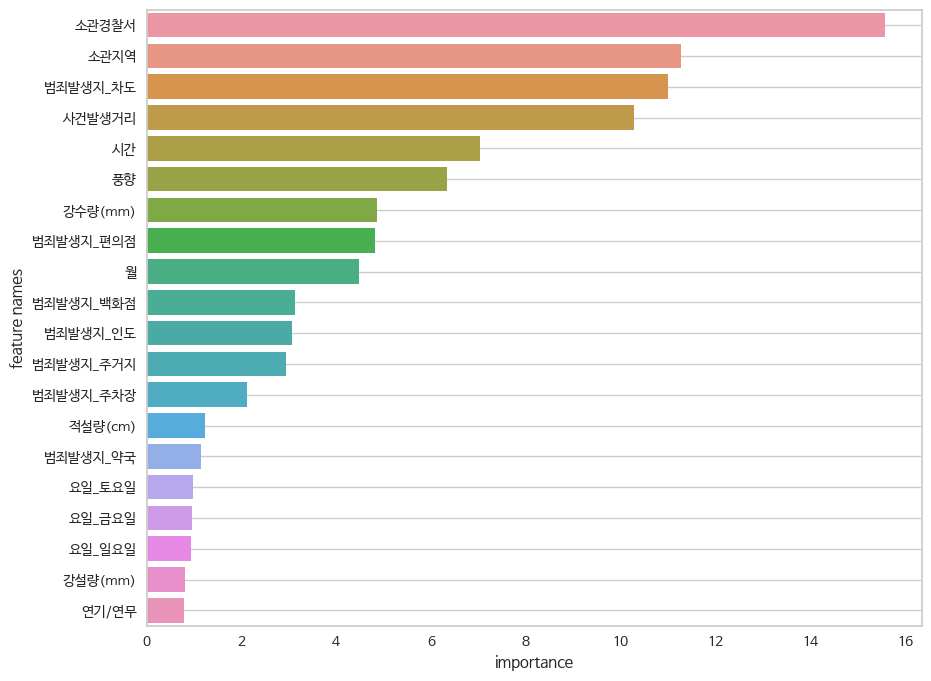

In [ ]:
plot_feature_importance(model_cb.feature_importances_, list(x),20)
plt.rc('font', family='NanumBarunGothic') 

## 3-5. Pycaret을 활용
- AutoML

In [ ]:
clf = setup(data = df, 
            target= "TARGET",
            verbose = True,
            remove_outliers = True,
            ) 

,Description,Value
0,Session id,3191
1,Target,TARGET
2,Target type,Multiclass
3,Original data shape,"(84406, 20)"
4,Transformed data shape,"(81451, 39)"
5,Transformed train set shape,"(56129, 39)"
6,Transformed test set shape,"(25322, 39)"
7,Numeric features,16
8,Categorical features,3
9,Preprocess,True


In [ ]:
pred_cb = model_cb.predict(test_df)

In [ ]:
best_models = compare_models(sort='f1', n_select=5, fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.5164,0.6440,0.5164,0.5087,0.5062,0.2404,0.2440,14.4920
knn,K Neighbors Classifier,0.4168,0.5528,0.4168,0.3973,0.3937,0.0670,0.0699,8.3460
ridge,Ridge Classifier,0.4809,0.0000,0.4809,0.3795,0.3805,0.1152,0.1698,1.3620
svm,SVM - Linear Kernel,0.4079,0.0000,0.4079,0.4668,0.2911,0.0397,0.0607,7.1560
dummy,Dummy Classifier,0.4319,0.5000,0.4319,0.1865,0.2605,0.0000,0.0000,1.1260
nb,Naive Bayes,0.3416,0.6373,0.3416,0.4558,0.2358,0.0426,0.0884,1.0420
qda,Quadratic Discriminant Analysis,0.3533,0.5000,0.3533,0.1289,0.1877,0.0000,0.0000,1.2600
dt,Decision Tree Classifier,0.3009,0.5000,0.3009,0.0905,0.1392,0.0000,0.0000,1.3800
rf,Random Forest Classifier,0.3009,0.5209,0.3009,0.0905,0.1392,0.0000,0.0000,4.0980
ada,Ada Boost Classifier,0.3009,0.5000,0.3009,0.0905,0.1392,0.0000,0.0000,3.1220


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [ ]:
blended_models = blend_models(best_models, fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4840,0.0000,0.4840,0.5114,0.3914,0.1258,0.1736
1,0.4865,0.0000,0.4865,0.4858,0.3906,0.1287,0.1805
2,0.4661,0.0000,0.4661,0.5582,0.3448,0.0758,0.1478
3,0.4576,0.0000,0.4576,0.5449,0.3275,0.0575,0.1265
4,0.4550,0.0000,0.4550,0.4870,0.3258,0.0536,0.1155
Mean,0.4698,0.0000,0.4698,0.5175,0.3560,0.0883,0.1488
Std,0.0131,0.0000,0.0131,0.0296,0.0293,0.0327,0.0254


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
total_models = []
models()

In [ ]:
top5_models = compare_models(fold = 5, round = 3, sort = 'f1', n_select = 5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.516,0.644,0.516,0.509,0.506,0.240,0.244,1.332
knn,K Neighbors Classifier,0.417,0.553,0.417,0.397,0.394,0.067,0.070,7.448
ridge,Ridge Classifier,0.481,0.000,0.481,0.379,0.381,0.115,0.170,0.532
svm,SVM - Linear Kernel,0.408,0.000,0.408,0.467,0.291,0.040,0.061,0.496
dummy,Dummy Classifier,0.432,0.500,0.432,0.187,0.261,0.000,0.000,0.562
nb,Naive Bayes,0.342,0.637,0.342,0.456,0.236,0.043,0.088,0.686
qda,Quadratic Discriminant Analysis,0.353,0.500,0.353,0.129,0.188,0.000,0.000,0.772
dt,Decision Tree Classifier,0.301,0.500,0.301,0.091,0.139,0.000,0.000,0.888
rf,Random Forest Classifier,0.301,0.521,0.301,0.091,0.139,0.000,0.000,1.106
ada,Ada Boost Classifier,0.301,0.500,0.301,0.091,0.139,0.000,0.000,0.760


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [ ]:
model_lr = create_model('lr', fold = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5122,0.6364,0.5122,0.5050,0.5035,0.2356,0.2385
1,0.5199,0.6517,0.5199,0.5111,0.5079,0.2440,0.2485
2,0.5202,0.6444,0.5202,0.5144,0.5113,0.2475,0.2509
3,0.5128,0.6446,0.5128,0.5048,0.5022,0.2347,0.2383
4,0.5169,0.6428,0.5169,0.5080,0.5061,0.2404,0.2441
Mean,0.5164,0.6440,0.5164,0.5087,0.5062,0.2404,0.2440
Std,0.0034,0.0049,0.0034,0.0037,0.0032,0.0049,0.0051


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
finalized_models = finalize_model(model_lr)

In [ ]:
predictions = predict_model(data=test_data, estimator=finalized_models)
predictions

,ID,월,시간,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),풍향,...,범죄발생지_인도,범죄발생지_주거지,범죄발생지_주유소,범죄발생지_주차장,범죄발생지_차도,범죄발생지_편의점,범죄발생지_학교,범죄발생지_호텔/모텔,prediction_label,prediction_score
0,TEST_00000,9,5,927,28.0,1.570654,19.625000,0.0,0.0,165.0,...,0,0,0,0,1,0,0,0,0,0.3762
1,TEST_00001,5,3,926,28.0,1.712457,21.444445,0.0,0.0,175.0,...,0,0,0,0,0,0,0,0,0,0.5549
2,TEST_00002,5,6,1437,33.0,0.447496,25.200001,0.0,0.0,290.0,...,0,1,0,0,0,0,0,0,0,0.5136
3,TEST_00003,11,1,1739,31.0,0.878585,0.000000,0.0,0.0,285.0,...,0,1,0,0,0,0,0,0,0,0.4992
4,TEST_00004,10,10,830,15.0,0.496423,26.142857,0.0,0.0,95.0,...,0,1,0,0,0,0,0,0,0,0.5317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17284,TEST_17284,11,9,1138,31.0,2.500387,0.000000,0.0,0.0,345.0,...,0,0,0,0,1,0,0,0,1,0.4744
17285,TEST_17285,3,1,148,9.0,2.234593,0.000000,0.0,0.0,270.0,...,0,1,0,0,0,0,0,0,0,0.4728
17286,TEST_17286,10,9,2347,53.0,0.360005,6.857143,0.0,0.0,340.0,...,0,1,0,0,0,0,0,0,1,0.4089
17287,TEST_17287,9,4,548,13.0,3.993724,0.000000,0.0,0.0,110.0,...,0,1,0,0,0,0,0,0,0,0.5076


In [ ]:
prediction = predict_model(finalized_models, data = test_data)
prediction.head()

,ID,월,요일,시간,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),...,안개,짙은안개,번개,진눈깨비,서리,연기/연무,눈날림,범죄발생지,prediction_label,prediction_score
0,TEST_00000,9,금요일,5,927,28.0,1.570654,19.625000,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,차도,2,0.4185
1,TEST_00001,5,수요일,3,926,28.0,1.712457,21.444445,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,식당,1,0.3656
2,TEST_00002,5,월요일,6,1437,33.0,0.447496,25.200001,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,주거지,0,0.5705
3,TEST_00003,11,화요일,1,1739,31.0,0.878585,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,주거지,0,0.5290
4,TEST_00004,10,목요일,10,830,15.0,0.496423,26.142857,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,주거지,0,0.5681


In [ ]:
predictions["prediction_label"].unique()

array([0, 1, 2])

In [ ]:
result["TARGET"]= predictions["prediction_label"]
result.to_csv("result.csv",index = False)

# Test data Load

In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/open (2)/test.csv")
result = pd.read_csv("/content/drive/MyDrive/open (2)/sample_submission.csv")

In [ ]:
test_df.drop(columns = ["ID"],inplace=True)
test_df = pd.get_dummies(test_df, columns=["요일","범죄발생지"])

In [ ]:
result.head(5)

,ID,TARGET
0,TEST_00000,0
1,TEST_00001,0
2,TEST_00002,0
3,TEST_00003,0
4,TEST_00004,0
